# Importing libraries.

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import catboost as ctb
import lightgbm as lgb
import os

from scipy.stats import iqr, normaltest
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

# Acquiring the data.

In [2]:
train_data = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

# Exploratory data analysis.

## Overall data analysis.

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Testing quantitative data for normality.

In [5]:
quantitative_features = train_data.select_dtypes(exclude = "object")

for quantitative_feature in quantitative_features:
    if normaltest(a = quantitative_features[quantitative_feature], nan_policy = "omit").pvalue <= .01:
        pass
    else:
        print(f"P-value is greater than 1% for {quantitative_feature}.")

### For each quantitative feature and target the p-value is less than 1%, indicating that the quantitative data are not normally distributed.

## Exploring the correlation.

<AxesSubplot:>

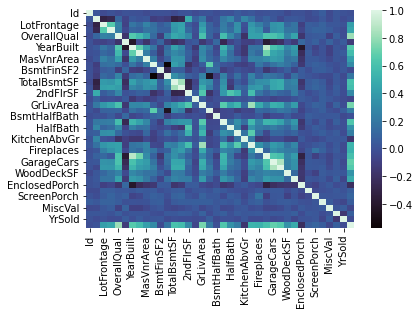

In [6]:
sns.heatmap(data = quantitative_features.corr(method = "spearman"), cmap = "mako")

# Feature preprocessing.

## Dropping the "Id" column.

In [7]:
train_data.drop("Id", axis = 1, inplace = True)
test_data.drop("Id", axis = 1, inplace = True)

## Getting the "SalePrice" column.

In [8]:
y = train_data["SalePrice"]

train_data.drop("SalePrice", axis = 1, inplace = True)

## Handling NaN values.

### Identifying NaN values in the training data.

In [9]:
train_nan_values = train_data.isna().sum()
train_nan_values[train_nan_values > 0].sort_values(ascending = False) / len(train_data) * 100

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

### Identifying NaN values in the testing data.

In [10]:
test_nan_values = test_data.isna().sum()
test_nan_values[test_nan_values > 0].sort_values(ascending = False) / len(test_data) * 100

PoolQC          99.794380
MiscFeature     96.504455
Alley           92.666210
Fence           80.123372
FireplaceQu     50.034270
LotFrontage     15.558602
GarageCond       5.346127
GarageYrBlt      5.346127
GarageQual       5.346127
GarageFinish     5.346127
GarageType       5.209047
BsmtCond         3.084304
BsmtExposure     3.015764
BsmtQual         3.015764
BsmtFinType1     2.878684
BsmtFinType2     2.878684
MasVnrType       1.096642
MasVnrArea       1.028101
MSZoning         0.274160
BsmtFullBath     0.137080
BsmtHalfBath     0.137080
Functional       0.137080
Utilities        0.137080
GarageCars       0.068540
GarageArea       0.068540
TotalBsmtSF      0.068540
KitchenQual      0.068540
BsmtUnfSF        0.068540
BsmtFinSF2       0.068540
BsmtFinSF1       0.068540
Exterior2nd      0.068540
Exterior1st      0.068540
SaleType         0.068540
dtype: float64

### Filling nan values in qualitative features of the training data.

In [11]:
train_qualitative_features = train_data.select_dtypes(include = "object")

In [12]:
train_qualitative_nan_features = train_qualitative_features.loc[:, train_qualitative_features.isna().any()].columns
train_qualitative_nan_features

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

In [13]:
for feature in ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 
                'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
                'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                'PoolQC','Fence', 'MiscFeature']:
    train_data[feature].fillna(value = "None", inplace = True)
    
train_data["Electrical"].fillna(value = train_data["Electrical"].mode(), inplace = True)

### Filling nan values in qualitative features of the testing data.

In [14]:
test_qualitative_features = test_data.select_dtypes(include = "object")

In [15]:
test_qualitative_nan_features = test_qualitative_features.loc[:, test_qualitative_features.isna().any()].columns
test_qualitative_nan_features

Index(['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')

In [16]:
for feature in ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 
                'KitchenQual', 'Functional', 'SaleType']:
    test_data[feature].fillna(value = test_data[feature].mode()[0], inplace = True)

for feature in ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 
                'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
                'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                'PoolQC','Fence', 'MiscFeature']:
    test_data[feature].fillna(value = "None", inplace = True)

### Filling nan values in quantitative features of the training data.

In [17]:
train_quantitative_features = train_data.select_dtypes(exclude = "object")

In [18]:
train_quantitative_nan_features = train_quantitative_features.loc[:, train_quantitative_features.isna().any()].columns
train_quantitative_nan_features

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [19]:
train_data["LotFrontage"].fillna(value = train_data["LotFrontage"].median(), inplace = True)
train_data["MasVnrArea"].fillna(value = train_data["MasVnrArea"].median(), inplace = True)
train_data["GarageYrBlt"].fillna(value = 0, inplace = True)

### Filling nan values in quantitative features of the testing data.

In [20]:
test_quantitative_features = test_data.select_dtypes(exclude = "object")

In [21]:
test_quantitative_nan_features = test_quantitative_features.loc[:, test_quantitative_features.isna().any()].columns
test_quantitative_nan_features

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')

In [22]:
test_data["LotFrontage"].fillna(value = test_data["LotFrontage"].median(), inplace = True)
test_data["MasVnrArea"].fillna(value = test_data["MasVnrArea"].median(), inplace = True)

for feature in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
                'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt','GarageCars', 
                'GarageArea']:
    test_data[feature].fillna(value = 0, inplace = True)

## Handling outliers.

### Identifying outliers.

In [23]:
#df_quantitative_features = df_merged.select_dtypes(exclude = "object")

In [24]:
#def setting_fences(feature):
#    q1, q3 = feature.quantile([.25, .75])
#    i_q_r = iqr(feature, nan_policy = "raise")
#    lower_fence = q1 - (1.5 * i_q_r)
#    upper_fence = q3 + (1.5 * i_q_r)
#    return lower_fence, upper_fence

In [25]:
#df_fences = df_quantitative_features.apply(lambda x: setting_fences(x))

#df_fences

## Standardization (normalization) quantitative values.

In [26]:
scaler = StandardScaler()

### Standardization of the training data.

In [27]:
train_quantitative_features = train_data.select_dtypes(exclude = "object")

In [28]:
train_scaled_quantitative_features = scaler.fit_transform(train_quantitative_features)
train_scaled_quantitative_features = pd.DataFrame(train_scaled_quantitative_features)

train_scaled_quantitative_features.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,...,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777
1,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,...,-0.060731,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439
2,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,...,0.631726,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777
3,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,...,0.790804,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655
4,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,...,1.698485,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777


### Standardization of the testing data.

In [29]:
test_quantitative_features = test_data.select_dtypes(exclude = "object")

In [30]:
test_scaled_quantitative_features = scaler.transform(test_quantitative_features)
test_scaled_quantitative_features = pd.DataFrame(test_scaled_quantitative_features)

test_scaled_quantitative_features.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,-0.872563,0.460320,0.110763,-0.795151,0.381743,-0.340077,-1.156380,-0.570750,0.053428,0.604293,...,1.202536,0.365179,-0.704483,-0.359325,-0.116339,1.882709,-0.068692,-0.087688,-0.119110,1.64521
1,-0.872563,0.505733,0.375850,-0.071836,0.381743,-0.439440,-1.301740,0.027027,1.051363,-0.288653,...,-0.753188,2.384400,-0.160950,-0.359325,-0.116339,-0.270208,-0.068692,25.116309,-0.119110,1.64521
2,0.073375,0.187842,0.332053,-0.795151,-0.517200,0.852269,0.636400,-0.570750,0.761852,-0.288653,...,0.042202,0.939819,-0.191147,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.229111,1.64521
3,0.073375,0.369494,-0.054002,-0.071836,0.381743,0.885390,0.636400,-0.460051,0.347326,-0.288653,...,-0.013943,2.121024,-0.160950,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.119110,1.64521
4,1.492282,-1.219961,-0.552407,1.374795,-0.517200,0.686666,0.345679,-0.570750,-0.396190,-0.288653,...,0.154492,-0.752176,0.533564,-0.359325,-0.116339,2.313293,-0.068692,-0.087688,-1.969111,1.64521


## Encoding qualitative features:

In [31]:
encoder = OneHotEncoder(handle_unknown = "ignore", drop = "first")

### Encoding qualitative features of the training data:

In [32]:
train_qualitative_features = train_data.select_dtypes(include = "object")

In [33]:
train_encoded_qualitative_features = encoder.fit_transform(train_qualitative_features)
train_encoded_qualitative_features = pd.DataFrame(train_encoded_qualitative_features.toarray())

train_encoded_qualitative_features.head()

,0,1,2,3,4,5,6,7,8,9,...,214,215,216,217,218,219,220,221,222,223
0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Encoding qualitative features of the testing data:

In [34]:
test_qualitative_features = test_data.select_dtypes(include = "object")

In [35]:
test_encoded_qualitative_features = encoder.transform(test_qualitative_features)
test_encoded_qualitative_features = pd.DataFrame(test_encoded_qualitative_features.toarray())

test_encoded_qualitative_features.head()

,0,1,2,3,4,5,6,7,8,9,...,214,215,216,217,218,219,220,221,222,223
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Merging the data together.

In [36]:
train_preprocessed_data = pd.concat([train_scaled_quantitative_features, train_encoded_qualitative_features], axis = 1)

train_preprocessed_data.head()

,0,1,2,3,4,5,6,7,8,9,...,214,215,216,217,218,219,220,221,222,223
0,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [37]:
test_preprocessed_data = pd.concat([test_scaled_quantitative_features, test_encoded_qualitative_features], axis = 1)

test_preprocessed_data.head()

,0,1,2,3,4,5,6,7,8,9,...,214,215,216,217,218,219,220,221,222,223
0,-0.872563,0.460320,0.110763,-0.795151,0.381743,-0.340077,-1.156380,-0.570750,0.053428,0.604293,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.872563,0.505733,0.375850,-0.071836,0.381743,-0.439440,-1.301740,0.027027,1.051363,-0.288653,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.073375,0.187842,0.332053,-0.795151,-0.517200,0.852269,0.636400,-0.570750,0.761852,-0.288653,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.073375,0.369494,-0.054002,-0.071836,0.381743,0.885390,0.636400,-0.460051,0.347326,-0.288653,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.492282,-1.219961,-0.552407,1.374795,-0.517200,0.686666,0.345679,-0.570750,-0.396190,-0.288653,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Feature selection.

In [ ]:
selector = VarianceThreshold(threshold = .1)

In [ ]:
train_processed_data = pd.DataFrame(selector.fit_transform(train_preprocessed_data))

train_processed_data.head()

In [ ]:
test_processed_data = pd.DataFrame(selector.fit_transform(test_preprocessed_data))

test_processed_data.head()

## Removing redundant columns from the testing data.

In [ ]:
redundant_columns = set(test_processed_data.columns) - set(train_processed_data.columns)

for column in redundant_columns:
    test_processed_data.drop(column, axis = 1, inplace = True)
    
test_processed_data = test_processed_data[train_processed_data.columns]

# Building models.

## XGBoost.

In [ ]:
xgboost = xgb.XGBRegressor(learning_rate = 0.01, 
                           n_estimators = 3460,
                           max_depth = 3, 
                           min_child_weight = 0,
                           gamma = 0, 
                           subsample = 0.7,
                           colsample_bytree = 0.7, 
                           nthread = -1,
                           scale_pos_weight = 1, 
                           seed = 21,
                           reg_alpha = 0.00006)

## CatBoost.

In [ ]:
catboost = ctb.CatBoostRegressor(learning_rate = 0.01,
                                 n_estimators = 3460,
                                 max_depth = 3,
                                 silent = True)

## LightGBM.

In [ ]:
lightgbm = lgb.LGBMRegressor(learning_rate = 0.01, 
                             n_estimators = 3460,
                             max_depth = 3, 
                             min_child_weight = 0,
                             subsample = 0.7,
                             colsample_bytree = 0.7, 
                             n_jobs = -1,
                             scale_pos_weight = 1, 
                             seed = 21,
                             reg_alpha = 0.00006)

# Cross-validation.

In [ ]:
kf = KFold(n_splits = 3, shuffle = True, random_state = 21)

In [ ]:
xgboost_scores = cross_validate(estimator = xgboost,
                                X = train_processed_data,
                                y = y, 
                                scoring = "neg_root_mean_squared_error",
                                cv = kf)

In [ ]:
catboost_scores = cross_validate(estimator = catboost,
                                 X = train_processed_data, 
                                 y = y, 
                                 scoring = "neg_root_mean_squared_error",
                                 cv = kf)

In [ ]:
lightgbm_scores = cross_validate(estimator = lightgbm,
                                 X = train_processed_data, 
                                 y = y, 
                                 scoring = "neg_root_mean_squared_error",
                                 cv = kf)

In [ ]:
xgboost_scores

In [ ]:
catboost_scores

In [ ]:
lightgbm_scores

# Blending models.

In [ ]:
xgboost.fit(train_processed_data, y)
catboost.fit(train_processed_data, y)
lightgbm.fit(train_processed_data, y)

In [ ]:
xgboost_predictions = xgboost.predict(test_processed_data)
catboost_predictions = catboost.predict(test_processed_data)
lightgbm_predictions = lightgbm.predict(test_processed_data)

In [ ]:
predictions = (.1 * xgboost_predictions) + (.8 * catboost_predictions) + (.1 * lightgbm_predictions)

# Making a submission.

In [ ]:
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
submission = pd.DataFrame({"Id": submission["Id"], "SalePrice": predictions})
submission.to_csv("submission.csv", index = False)

submission